# Advanced Data Mining and Analysis in Python
## Exploring User Behavior on an E-commerce Website: An EDA of User Session Data
**In this exercise, we will conduct an exploratory data analysis (EDA) on a dataset that contains information regarding user sessions on an e-commerce website.**  

Our analysis will involve addressing the presence of **missing values**, as well as **optimizing data types**, in order to facilitate the creation of new variables that provide additional insights into the data.  

To this end, we will leverage the existing data to **engineer new columns** that will augment our understanding of the dataset.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
FILE_PATH = '/data/notebook_files/Exercise2_cosmetics.csv'
data = pd.read_csv(FILE_PATH)

/opt/python/envs/default/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## EDA step - Understanding the data
Before we'll start the exercise and answer the questions, let's first understand what we're facing with - our data.

In [3]:
print (f'The length of the dataset is {len(data)} entries')

The length of the dataset is 1048575 entries


In [4]:
data.sample(5)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
127910,2019-11-02 05:38:23,view,5826000,1487580005092290000,NaN,lianail,6.33,514003567,a74a7d82-d513-4ecd-97ba-054dc7ed7e60
204740,2019-11-02 18:32:08,view,5793062,1487580005754990000,NaN,NaN,7.62,432943261,86597895-9f16-3c0e-09f3-ec48b1f767c9
185499,2019-11-02 15:54:29,purchase,5799891,1487580009051710000,NaN,NaN,19.03,566774731,ff5bb494-bc6c-417e-b9ae-c73a90e4872b
317382,2019-11-03 17:06:40,cart,5831651,1783999068909860000,NaN,NaN,15.87,545046026,66ed1403-4f69-413c-98f8-67d80408d6fa
233483,2019-11-03 00:46:42,remove_from_cart,5815492,1487580010125450000,NaN,NaN,1.43,472295371,1980f7e2-9f8d-44c5-992f-a9a46d9d8619


### Missing Values:

Let's check the missing values:

In [5]:
data.isna().sum().sort_values(ascending = False)

category_code 1031860
brand 446124
user_session 218
event_time 0
event_type 0
product_id 0
category_id 0
price 0
user_id 0
dtype: int64

Since we won't use `category_code` for this exercise, and since we can't know how to fill correctly the missing values, we'll ignore them.  

**And about the `user_session` column:**

In [6]:
print("The rows that don't have 'user_session' values are {:.4f}% of the dataset".format((data.user_session.isna().sum()/len(data))*100))

The rows that don't have 'user_session' values are 0.0208% of the dataset


**Because it's very small part of the dataset, we'll drop them.**

In [7]:
data.dropna(subset=['user_session'], inplace = True)

### Data Types
Let's check the data types:

In [8]:
data.dtypes

event_time object
event_type object
product_id int64
category_id int64
category_code object
brand object
price object
user_id int64
user_session object
dtype: object

We see that there's a lot of 'object' types, which will make our analysis harder or even impossible.  
So, to make it easier, we'll convert the following columns into different types:  

* **event_time**: str -> datetime.
* **price**: str -> int.

In [9]:
# Example
str = '2.44 sale'
re.findall("\d+\.\d+",str)[0]

'2.44'

In [10]:
data.price = data.price.astype('str') # First, make sure the column contains only strings so the 're' methods will work on it. 
data.price = data.price.apply(lambda x: re.findall('\d+\.\d+',x)[0]) # Extract the number from the string.
data.price = data.price.astype('float') # Convert the price column to floats.
data.event_time = pd.to_datetime(data.event_time) # Convert 'event time' to datetime objects.
data['event_date'] = data.event_time.apply(lambda x: x.date()) # We'll add 'event_column'.

We can **re-order the columns** for more <u>logical order</u>, so the `user_id` and the `user_session` we'll be alongside the `event_time` in the **beginning** of each row.

In [11]:
data = data[['user_id', 'user_session','event_date', 'event_time', 'event_type',
                   'product_id', 'category_id', 'category_code', 'brand', 'price']]

Make sure the dataset order by sessions and dates:

In [12]:
data.sort_values(by = ['user_session','event_time'], inplace = True)

### The Questions

1. **Add 'duration_to_next_event' column, which indicates the time duration between the current and the next event, that's for each session.**  

Because we're talking about sessions, we have to group the dataset by them. then we'll perform the calculation by subtraction the time between the next and the current event (using the `shift` method).  

Then, we'll move the vector of those time differences <u>one row back</u>, convert it to seconds and <u>fill the nulls with zeros</u>.

In [13]:
data['duration_to_next_event'] = data.event_time.shift(-1) - data.event_time
data['duration_to_next_event'] = data['duration_to_next_event'].apply(lambda x: x.total_seconds())

# Keep the Original Indexes.
data['id'] = data.index

# Create list of the indexes of each last row of each session.
last_idx = [i for i in data.groupby('user_session', as_index=False).last()['id'].values]

# Replace the value of the rows that appears in the list to zero.
data.loc[data['id'].isin(last_idx), 'duration_to_next_event'] = 0

# Drop the 'id' column.
data.drop(columns='id', inplace = True)

In [14]:
### While it may take longer to run, I believe this is a more elegant solution.

# # Calculate the difference between every two rows.
# data['duration_to_next_event'] = data.groupby('user_session')\
#     .apply(lambda x: (x.event_time - x.event_time.shift(1)).shift(-1)).values

# # Convert the result to seconds.
# data['duration_to_next_event'] = data['duration_to_next_event'].map(lambda y: y.total_seconds())

# # Fill the last row with zero.
# data['duration_to_next_event'].fillna(0, inplace = True)

2. **Add 'funnel_number' column.**

**'Funnel'** is <u>sequence of visits (sessions)</u> that made by the **same user** (identified by user_id) within **range of less than 5 days**.  
In order to retrive this feature, first we'll **extract the number of days passed bewteen each two sessions:**

In [15]:
# Keep the Original Indexes.
data['id'] = data.index

# Create Temporary Dataframe which includes the last row for each date for each id row.
temp_df = data.groupby(by=['user_id','event_date'], as_index = False).last()

# Add 'Funnel' Column which similar to the previous question.
temp_df['days_gap'] = temp_df.event_date.shift(-1) - temp_df.event_date
temp_df['days_gap'] = temp_df.days_gap.apply(lambda x: x.days)

# Hold the last indexes for each 'user_id' row
last_idx = [i for i in temp_df.groupby(by=['user_id'], as_index=False).last()['id'].values]

# Replace the value of each last row for each user to zero (because the next row is another user).
temp_df.loc[temp_df['id'].isin(last_idx), 'days_gap'] = 0

# Set the index as the id - to join it to the original data by index.
temp_df.set_index('id',inplace=True)

# Hold the funnels as Series.
days = temp_df.days_gap

# Join the funnels with the entire data.
data = data.join(days, how='left').fillna(0)

# Drop the 'id' column.
data.drop(columns='id', inplace = True)

**After we create this column, we can get back to order by user_id, event_time and user_session.**

In [16]:
data.sort_values(by = ['user_id','event_time'], inplace = True)

**Now we'll add the 'funnel_number' column.**  
We'll use for loop which will iterate over the user_ids, and sub-loop which will iterate over the slice of those ids.

In [17]:
# Set new column.
data['funnel_number'] = 0

# The outer loop iterates over each user. The inner loop iterates over each slice of each user_id.
for user in data.user_id.unique():
    funnel_number = 1
    for index, row in data[data.user_id == user].iterrows():
        if row.days_gap < 5: # Means the session is still under the same funnel.
            data.at[index, 'funnel_number'] = funnel_number # Inserts the funnel number.
        else: # Means it's the last session for the current funnel.
            data.at[index, 'funnel_number'] = funnel_number # Inserts the funnel number.
            funnel_number += 1 # Adds 1 for the funnel number.

Here's an example for one id with 2 funnels:

In [18]:
data[data.user_id==567277662].head()

,user_id,user_session,event_date,event_time,event_type,product_id,category_id,category_code,brand,price,duration_to_next_event,days_gap,funnel_number
355560,567277662,745ca0bb-134d-4094-87d2-123f275291cd,2019-11-03,2019-11-03 22:32:32,view,5841195,1487580009051710000,0,0,47.59,1000.0,0.0,1
356376,567277662,745ca0bb-134d-4094-87d2-123f275291cd,2019-11-03,2019-11-03 22:49:12,cart,5615144,1487580005092290000,0,0,4.76,0.0,5.0,1
981581,567277662,c84cac0f-40de-400e-9ed2-a7899aee34b7,2019-11-08,2019-11-08 01:04:02,view,5615144,1487580005092290000,0,0,4.76,186.0,0.0,2
981693,567277662,c84cac0f-40de-400e-9ed2-a7899aee34b7,2019-11-08,2019-11-08 01:07:08,view,5730206,1487580005092290000,0,0,10.32,200.0,0.0,2
981771,567277662,c84cac0f-40de-400e-9ed2-a7899aee34b7,2019-11-08,2019-11-08 01:10:28,view,5599264,1487580005553660000,0,0,7.14,115.0,0.0,2


3. **Add 'index_in_funnel' column.**

We'll use `group_by` method to group by 'user_id' and 'funnel_number' and then `cumcount` to count the rows.

In [19]:
data['index_in_funnel'] = data.groupby(['user_id','funnel_number']).cumcount() + 1

4. **Convert and handle string in 'price' column.**

Solved as part of the EDA process.

5. **Add 'index_in_funnel' column.**

In [20]:
print(f'The Event types that exist are: {data.event_type.unique()}')

The Event types that exist are: ['view' 'cart' 'purchase' 'remove_from_cart']


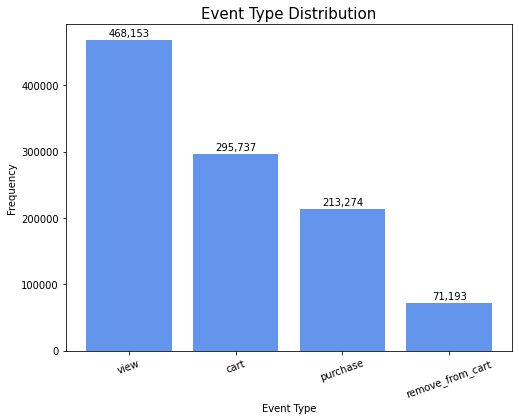

In [21]:
plt.figure(figsize=(8, 6))
bar = plt.bar(data.event_type.unique(),data.event_type.value_counts(), color = 'cornflowerblue')
plt.title("Event Type Distribution", fontsize = 15)
plt.xlabel("Event Type")
plt.xticks(rotation=20)
plt.ylabel("Frequency")
plt.bar_label(bar, labels=[f'{e:,.0f}' for e in data.event_type.value_counts()], padding=2, color='black', fontsize=10);

6. **Create 'Session Data' DataFrame.**

**Create 'event_number' column:**

In [22]:
new_columns = pd.DataFrame(columns=['event_number','visit_duration', 'list_of_viewed', 'list_of_added_to_cart', 'list_of_purchased'])

# Create 'event_number' column.
new_columns['event_number'] = data.groupby('user_session').count().user_id

# Create 'visit_duration' column.
new_columns['visit_duration'] = data.groupby('user_session').last().event_time - data.groupby('user_session').first().event_time
# duration['visit_duration'] = duration['visit_duration'].apply(lambda x: x.total_seconds()) # If you want the duration in seconds.

# Create 'list_of_viewed' column.
new_columns['list_of_viewed'] = data.groupby('user_session').product_id.unique()

# Create 'list_of_added_to_cart' column
new_columns['list_of_added_to_cart'] = data[data.event_type == 'cart'].groupby('user_session').product_id.unique()

# Create 'list_of_purchased' column
new_columns['list_of_purchased'] = data[data.event_type == 'purchase'].groupby('user_session').product_id.unique()

# Merge the new columns with our data.
data = pd.merge(data, new_columns, on='user_session', how='left')

In [23]:
session_data = data[['user_id','user_session','funnel_number','index_in_funnel','event_number','visit_duration', 'list_of_viewed', 'list_of_added_to_cart', 'list_of_purchased']]

**Here's an example of the new Data Frame:**

In [24]:
session_data.sample(10)

,user_id,user_session,funnel_number,index_in_funnel,event_number,visit_duration,list_of_viewed,list_of_added_to_cart,list_of_purchased
0,1120748,d0484d94-7ac1-44e8-a310-2360da11ad9d,1,1,1,0 days 00:00:00,[5240],NaN,NaN
1,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,1,4,0 days 00:02:56,"[5614842, 5766379]","[5614842, 5766379]","[5766379, 5614842]"
2,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,2,4,0 days 00:02:56,"[5614842, 5766379]","[5614842, 5766379]","[5766379, 5614842]"
3,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,3,4,0 days 00:02:56,"[5614842, 5766379]","[5614842, 5766379]","[5766379, 5614842]"
4,10079204,f873d16b-4efa-4e92-81be-92948aef2ff5,1,4,4,0 days 00:02:56,"[5614842, 5766379]","[5614842, 5766379]","[5766379, 5614842]"
5,10521214,25d2d492-d688-4baa-adf1-7296dbdd663e,1,1,3,0 days 00:02:13,"[5713294, 5713295]",NaN,NaN
6,10521214,25d2d492-d688-4baa-adf1-7296dbdd663e,1,2,3,0 days 00:02:13,"[5713294, 5713295]",NaN,NaN
7,10521214,25d2d492-d688-4baa-adf1-7296dbdd663e,1,3,3,0 days 00:02:13,"[5713294, 5713295]",NaN,NaN
8,11274156,0c778a88-4700-4e8b-becb-3371ec28ea79,1,1,2,0 days 00:00:20,"[5809910, 5899834]",[5809910],NaN
9,11274156,0c778a88-4700-4e8b-becb-3371ec28ea79,1,2,2,0 days 00:00:20,"[5809910, 5899834]",[5809910],NaN


**In conclusion**, this notebook presents an exploratory data analysis of user session data from an e-commerce website.  

By analyzing the dataset and addressing missing values, optimizing data types, and engineering new variables, **we were able to gain new insights into user behavior on the website**.  

Through this analysis, **we gained a deeper understanding** of website traffic, user engagement, and potential areas for business strategy. 